In [163]:
from IPython.display import HTML, display

import os

import numpy as np
import pandas as pd
from root_pandas import read_root, to_root

import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.base import BaseEstimator
from sklearn.grid_search import RandomizedSearchCV

from xgboost import XGBClassifier

from itertools import islice

from tqdm import tqdm

import ROOT

from collections import OrderedDict

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 14

# Read and prepare Data

In [3]:
data_dir = '/home/kheinicke/tank/flavourtagging/'
filenames = [
    data_dir + 'Bu2JpsiK_MuonTrainingTuple_2012_MD_sweighted_kheinick.root',
    data_dir + 'Bu2JpsiK_MuonTrainingTuple_2012_MU_sweighted_kheinick.root',
]
chunksize = 5000

In [4]:
# just define some keyword arguments for read_root in a separate dict
data_kwargs = dict(
    key='DecayTree',  # the tree name
    columns=['B_OS_Muon*',  # all branches that should be read
             'B_ID',
             'B_PT',
             'SigYield_sw'
            ],
    chunksize=chunksize,  # this will create a generator, yielding subsets with 'chunksize' of the data
    where='(B_LOKI_MASS_JpsiConstr_NoPVConstr>0)',  # a ROOT where selection, does not work with array-variables
    flatten=True  # will flatten the data in the dimension of the first given column
)

In [5]:
# still have to use plain ROOT to get the number of entries...
n_entries = 0
for fn in filenames:
    f = ROOT.TFile(fn)
    t = f.Get('DecayTree')
    n_entries += t.GetEntries()

In [6]:
# This will read chunks of the data inside a list comprehension and then concat those to a big dataframe
# note that tqdm is just some boilerplate to generate a progressbar
# df = pd.concat([df for df in tqdm(read_root(filenames, **data_kwargs), total=n_entries/chunksize)])

# only use the first 10 chunks to speed up read process and reduce RAM pressure for development
df = pd.concat([df for df in tqdm(islice(read_root(filenames, **data_kwargs), 10), total=10)])

100%|██████████| 10/10 [00:19<00:00,  1.86s/it]


In [7]:
df.shape

(3202977, 34)

In [8]:
df.replace(np.inf, 10000, inplace=True)
df.dropna(inplace=True)

In [9]:
df['target'] = np.sign(df.B_ID) == np.sign(df.B_OS_Muon_ID)

In [10]:
# use abs(phiDistance)
df.B_OS_Muon_phiDistance = np.abs(df.B_OS_Muon_phiDistance)

In [11]:
# scale the data to make it usable for TMVA aswell
# /= 1000 somehow kills the kernel. Maybe a bug in pandas?
df.B_OS_Muon_P *= 0.001
df.B_OS_Muon_PT *= 0.001
df.B_PT *= 0.001

In [260]:
# a nasty bit of code to display everything in a nice table
with pd.option_context('display.max_columns', None, 'display.max_rows', None):
    display(HTML(df.describe().to_html()))

,B_OS_Muon_DEC,B_OS_Muon_PROB,B_OS_Muon_PARTICLES_NUM,B_OS_Muon_ABSID,B_OS_Muon_P,B_OS_Muon_PT,B_OS_Muon_TRCHI2DOF,B_OS_Muon_BPVIPCHI2(),B_OS_Muon_TRTYPE,B_OS_Muon_PIDmu,B_OS_Muon_IPPUs,B_OS_Muon_TRGHP,B_OS_Muon_PROBNNmu,B_OS_Muon_PROBNNpi,B_OS_Muon_PROBNNe,B_OS_Muon_PROBNNk,B_OS_Muon_PROBNNp,B_OS_Muon_PP_HASMUONPID,B_OS_Muon_PP_MuonPIDStatus,B_OS_Muon_IsSignalDaughter,B_OS_Muon_Signal_P,B_OS_Muon_phiDistance,B_OS_Muon_MuonPIDIsMuon,B_OS_Muon_RecVertexIP,B_OS_Muon_countTracks,B_OS_Muon_Signal_PT,B_OS_Muon_ABS_RecVertexIP,B_OS_Muon_KEY,B_OS_Muon_Q,B_OS_Muon_ID,B_ID,B_PT,SigYield_sw,__array_index
count,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06,3.202975e+06
mean,-5.894520e-04,4.963348e-01,7.983014e+01,1.964313e+02,1.411508e+01,8.099842e-01,1.369438e+00,1.428027e+03,3.052793e+00,-2.090171e+00,1.834018e+03,9.496503e-02,-7.713597e-01,5.065439e-01,3.926915e-02,1.294321e-01,5.128326e-02,9.531145e-01,8.059544e+00,9.416027e-02,1.095291e+05,1.516547e+00,1.215710e-01,-7.522802e+00,5.300428e+01,5.890440e+03,4.235833e+01,2.409077e+01,4.365629e-03,1.207360e+00,1.056599e+01,5.890444e+00,8.387301e-01,3.941507e+01
std,1.468319e-01,2.469108e-02,3.674852e+01,8.600877e+01,1.719228e+01,9.411014e-01,5.600109e-01,2.294158e+04,2.236190e-01,4.830739e+00,3.807365e+03,1.227520e-01,5.223371e-01,3.701634e-01,1.511030e-01,2.349070e-01,1.061528e-01,2.113936e-01,8.490753e+00,2.920516e-01,6.857273e+04,9.273999e-01,3.267898e-01,1.187963e+02,2.152971e+01,4.411547e+03,1.112427e+02,2.715489e+01,9.999906e-01,2.144326e+02,5.208929e+02,4.411547e+00,6.362577e-01,3.132314e+01
min,-1.000000e+00,3.300000e-01,6.000000e+00,1.100000e+01,2.000000e+00,2.404586e-02,1.569664e-02,2.794452e-07,3.000000e+00,-1.402550e+01,1.419363e-03,0.000000e+00,-1.000000e+00,1.629600e-11,1.152776e-12,7.464647e-09,5.053078e-09,0.000000e+00,0.000000e+00,0.000000e+00,2.157805e+04,1.219611e-06,0.000000e+00,-3.200756e+03,3.000000e+00,3.523140e+01,1.025922e-03,0.000000e+00,-1.000000e+00,-3.210000e+02,-5.210000e+02,3.523140e-02,-1.553189e+00,0.000000e+00
25%,0.000000e+00,5.000000e-01,5.400000e+01,2.110000e+02,4.610885e+00,2.631437e-01,9.698763e-01,7.776059e-01,3.000000e+00,-5.870314e+00,2.167583e+00,1.147318e-02,-1.000000e+00,1.035505e-01,8.555922e-06,2.731317e-03,1.247896e-03,1.000000e+00,6.000000e+00,0.000000e+00,6.335276e+04,6.898171e-01,0.000000e+00,-2.315419e+00,3.800000e+01,2.845576e+03,1.330141e+00,5.000000e+00,-1.000000e+00,-2.110000e+02,-5.210000e+02,2.845576e+00,9.202347e-01,1.600000e+01
50%,0.000000e+00,5.000000e-01,7.400000e+01,2.110000e+02,8.205570e+00,5.018704e-01,1.247561e+00,2.788993e+00,3.000000e+00,-2.329757e+00,2.402797e+01,3.530880e-02,-1.000000e+00,5.494361e-01,1.282700e-04,2.230119e-02,1.017048e-02,1.000000e+00,6.000000e+00,0.000000e+00,9.126573e+04,1.492417e+00,0.000000e+00,7.410913e-01,5.100000e+01,4.845008e+03,4.268687e+00,1.500000e+01,1.000000e+00,1.100000e+01,5.210000e+02,4.845008e+00,1.123374e+00,3.300000e+01
75%,0.000000e+00,5.000000e-01,9.900000e+01,2.110000e+02,1.610729e+01,9.761887e-01,1.650789e+00,1.612128e+01,3.000000e+00,1.133154e+00,2.003958e+02,1.344777e-01,-1.000000e+00,8.764799e-01,2.518686e-03,1.150865e-01,4.796367e-02,1.000000e+00,6.000000e+00,0.000000e+00,1.346460e+05,2.328423e+00,0.000000e+00,8.230272e+00,6.500000e+01,7.691630e+03,3.047918e+01,3.400000e+01,1.000000e+00,2.110000e+02,5.210000e+02,7.691630e+00,1.163524e+00,5.600000e+01
max,1.000000e+00,5.000000e-01,3.310000e+02,3.210000e+02,1.999988e+02,9.999019e+00,2.999997e+00,5.156433e+06,4.000000e+00,1.461949e+01,1.000000e+04,4.999995e-01,9.997579e-01,9.999716e-01,9.999357e-01,9.999824e-01,9.990733e-01,1.000000e+00,3.100000e+01,1

# Build the meta classifier

In [261]:
classic_MVA_features = [
    'B_OS_Muon_countTracks',  # aka mult
    'B_OS_Muon_P',
    'B_OS_Muon_PT',
    'B_PT',
    'B_OS_Muon_ABS_RecVertexIP',  # aka IPs
    'B_OS_Muon_TRCHI2DOF',
    'B_OS_Muon_PROBNNmu',
    'B_OS_Muon_TRGHP',
    'B_OS_Muon_IPPUs',
]

In [262]:
# These are the classic cuts
# queries = [
#     'B_OS_Muon_P > 0',
#     'B_OS_Muon_PT > 0.5',
#     'B_OS_Muon_IsSignalDaughter == 0',
#     'B_OS_Muon_phiDistance > 0.005',
#     'B_OS_Muon_MuonPIDIsMuon == 1',
#     'B_OS_Muon_TRCHI2DOF < 3',
#     'B_OS_Muon_RecVertexIP > 0',
#     'B_OS_Muon_TRGHP < 0.4',
#     'B_OS_Muon_PROBNNmu > 0.35',
#     'B_OS_Muon_PROBNNpi < 0.8',
#     'B_OS_Muon_PROBNNe < 0.8',
#     'B_OS_Muon_PROBNNk < 0.8',
#     'B_OS_Muon_PROBNNp < 0.8',
# #    'SigYield_sw > 0'
# ]

In [306]:
train_data, test_data, train_labels, test_labels = train_test_split(df, df.target, test_size=0.5, random_state=0)

In [307]:
class CutBasedXGBClassifier(XGBClassifier):
    def __init__(self, max_depth=3, learning_rate=0.1, n_estimators=100,
                 silent=True, objective="reg:linear",
                 nthread=-1, gamma=0, min_child_weight=1, max_delta_step=0,
                 subsample=1, colsample_bytree=1, colsample_bylevel=1,
                 reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                 base_score=0.5, seed=0, missing=None,
                 P_column='B_OS_Muon_P', P_cut=0,
                 PT_column='B_OS_Muon_PT', PT_cut=0.5,
                 phiDistance_column='B_OS_Muon_phiDistance', phiDistance_cut=0.005,
                 MuonPIDIsMuon_column='B_OS_Muon_MuonPIDIsMuon', MuonPIDIsMuon_cut=1,
                 mvaFeatures=None, only_max_pt=True, event_identifier_column='B_PT',
                 IsSignalDaughter_column='B_OS_Muon_IsSignalDaughter', IsSignalDaughter_cut=0,
                 TRCHI2DOF_column='B_OS_Muon_TRCHI2DOF', TRCHI2DOF_cut=3,
                 TRGHP_column='B_OS_Muon_TRGHP', TRGHP_cut=0.4,
                 PROBNNmu_column='B_OS_Muon_PROBNNmu', PROBNNmu_cut=0.35,
                 PROBNNpi_column='B_OS_Muon_PROBNNpi', PROBNNpi_cut=0.8,
                 PROBNNe_column='B_OS_Muon_PROBNNe', PROBNNe_cut=0.8,
                 PROBNNk_column='B_OS_Muon_PROBNNk', PROBNNk_cut=0.8,
                 PROBNNp_column='B_OS_Muon_PROBNNp', PROBNNp_cut=0.8,
                ):
        self.cut_parameters = ['P', 'PT', 'phiDistance', 'MuonPIDIsMuon',
                               'IsSignalDaughter', 'TRCHI2DOF', 'TRGHP',
                               'PROBNNmu', 'PROBNNpi', 'PROBNNe', 'PROBNNk',
                               'PROBNNp',
                              ]
        for cp in self.cut_parameters:
            setattr(self, '{}_cut'.format(cp), locals()['{}_cut'.format(cp)])
            setattr(self, '{}_column'.format(cp), locals()['{}_column'.format(cp)])
        self.mvaFeatures = mvaFeatures
        self.only_max_pt = only_max_pt
        self.event_identifier_column = event_identifier_column
        super(CutBasedXGBClassifier, self).__init__(max_depth=max_depth, learning_rate=learning_rate,
                                                    n_estimators=n_estimators, silent=silent, objective=objective,
                                                    nthread=nthread, gamma=gamma, min_child_weight=min_child_weight,
                                                    max_delta_step=max_delta_step,
                                                    subsample=subsample, colsample_bytree=colsample_bytree,
                                                    colsample_bylevel=colsample_bylevel,
                                                    reg_alpha=reg_alpha, reg_lambda=reg_lambda,
                                                    scale_pos_weight=scale_pos_weight,
                                                    base_score=base_score, seed=seed, missing=None)

    def select(self, X, y=None):
        len_before = len(np.unique(X[self.event_identifier_column]))
        selection = ((X[self.P_column] > self.P_cut)
                     & (X[self.PT_column] > self.PT_cut)
                     & (X[self.phiDistance_column] > self.phiDistance_cut)
                     & (X[self.MuonPIDIsMuon_column] == self.MuonPIDIsMuon_cut)
                     & (X[self.IsSignalDaughter_column] == self.IsSignalDaughter_cut)
                     & (X[self.TRCHI2DOF_column] < self.TRCHI2DOF_cut)
                     & (X[self.TRGHP_column] < self.TRGHP_cut)
                     & (X[self.PROBNNmu_column] > self.PROBNNmu_cut)
                     & (X[self.PROBNNpi_column] < self.PROBNNpi_cut)
                     & (X[self.PROBNNe_column] < self.PROBNNe_cut)
                     & (X[self.PROBNNk_column] < self.PROBNNk_cut)
                     & (X[self.PROBNNp_column] < self.PROBNNp_cut)
                    )
        X = X[selection]        
        if y is not None:
            y = y[selection]
        
        if self.only_max_pt:
            X.reset_index(drop=True, inplace=True)
            max_pt_indices = X.groupby(self.event_identifier_column)['B_OS_Muon_PT'].agg(np.argmax).astype('int')
            X = X.iloc[max_pt_indices]
            if y is not None:
                y.reset_index(drop=True, inplace=True)
                y = y.iloc[max_pt_indices]
                
        print(len(np.unique(X[self.event_identifier_column])) / len_before * 100)

        if self.mvaFeatures:
            X = X[self.mvaFeatures]
        
        if y is not None:
            return X, y
        else:
            return X

    def get_params(self, deep=False):
        params = super(CutBasedXGBClassifier, self).get_params(deep=deep)
        for cp in self.cut_parameters:
            params['{}_cut'.format(cp)] = getattr(self, '{}_cut'.format(cp))
            params['{}_column'.format(cp)] = getattr(self, '{}_column'.format(cp))
        params['mvaFeatures'] = self.mvaFeatures
        params['only_max_pt'] = self.only_max_pt
        params['event_identifier_column'] = self.event_identifier_column
        return params

    def set_params(self, P_cut=None, PT_cut=None, phiDistance_cut=None,
                   MuonPIDIsMuon_cut=None, mvaFeatures=None, only_max_pt=None,
                   event_identifier_column=None, **kwargs):
        for cp in self.cut_parameters:
            if locals()['{}_cut'.format(cp)] is not None:
                setattr(self, '{}_cut'.format(cp), locals()['{}_cut'.format(cp)])
        if mvaFeatures:
            self.mvaFeatures = mvaFeatures
        if only_max_pt:
            self.only_max_pt = only_max_pt
        if event_identifier_column:
            self.event_identifier_column = event_identifier_column
        super(CutBasedXGBClassifier, self).set_params(**kwargs)
        return self

    def fit(self, X, y, eval_set=None, **kwargs):
        if eval_set is not None:
            eval_set = [self.select(X_, y_) for X_, y_ in eval_set]
        return super(CutBasedXGBClassifier, self).fit(*self.select(X, y), eval_set=eval_set, **kwargs)

    def predict_proba(self, data, **kwargs):
        return super(CutBasedXGBClassifier, self).predict_proba(self.select(data), **kwargs)

    def score(self, X, y, sample_weight=None):
        probas = self.predict_proba(X)[:,1]
        return roc_auc_score(self.select(X, y)[1], probas)

In [308]:
cbxgb = CutBasedXGBClassifier(mvaFeatures=classic_MVA_features, max_depth=5,
                              n_estimators=300, learning_rate=0.01, seed=1)

In [309]:
cbxgb.fit(train_data, train_labels)

8.294


CutBasedXGBClassifier(IsSignalDaughter_column='B_OS_Muon_IsSignalDaughter',
           IsSignalDaughter_cut=0,
           MuonPIDIsMuon_column='B_OS_Muon_MuonPIDIsMuon',
           MuonPIDIsMuon_cut=1, PROBNNe_column='B_OS_Muon_PROBNNe',
           PROBNNe_cut=0.8, PROBNNk_column='B_OS_Muon_PROBNNk',
           PROBNNk_cut=0.8, PROBNNmu_column='B_OS_Muon_PROBNNmu',
           PROBNNmu_cut=0.35, PROBNNp_column='B_OS_Muon_PROBNNp',
           PROBNNp_cut=0.8, PROBNNpi_column='B_OS_Muon_PROBNNpi',
           PROBNNpi_cut=0.8, PT_column='B_OS_Muon_PT', PT_cut=0.5,
           P_column='B_OS_Muon_P', P_cut=0,
           TRCHI2DOF_column='B_OS_Muon_TRCHI2DOF', TRCHI2DOF_cut=3,
           TRGHP_column='B_OS_Muon_TRGHP', TRGHP_cut=0.4, base_score=0.5,
           colsample_bylevel=1, colsample_bytree=1,
           event_identifier_column='B_PT', gamma=0, learning_rate=0.01,
           max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
           mvaFeatures=['B_OS_Muon_countTracks'

In [310]:
cbxgb.score(test_data, test_labels)

8.078000000000001
8.078000000000001


0.33256867461607681

In [311]:
cbxgb.score(train_data, train_labels)

8.294
8.294


0.8129734716321757

In [271]:
y_test = cbxgb.select(test_data, test_labels)[1]
probas = cbxgb.predict_proba(test_data)[:,1]

In [251]:
y_train = cbxgb.select(train_data, train_labels)[1]
probas_train = cbxgb.predict_proba(train_data)[:,1]

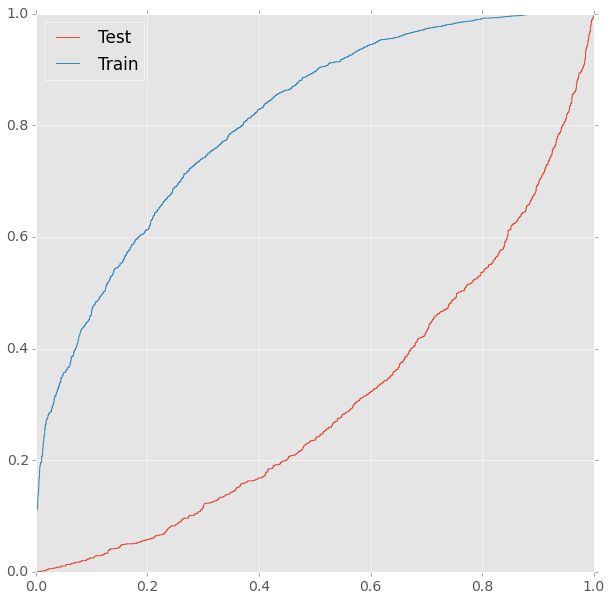

In [252]:
plt.plot(*roc_curve(y_test, probas)[:2], label='Test')
plt.plot(*roc_curve(y_train, probas_train)[:2], label='Train')
plt.legend(loc='best')
plt.show()

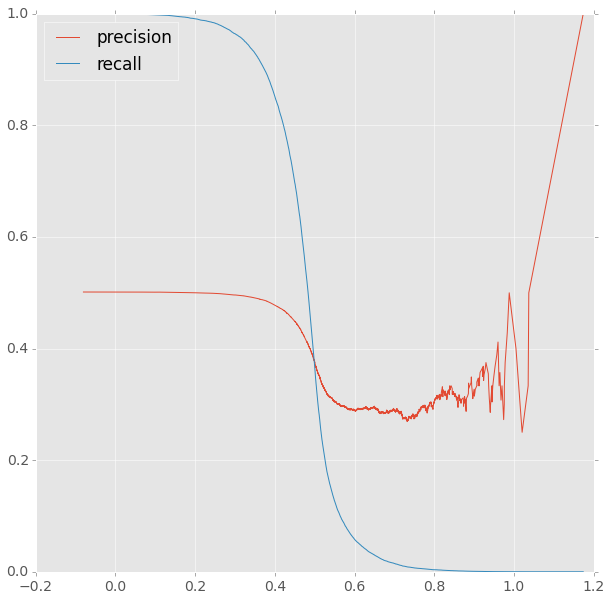

In [202]:
precision, recall, thresholds = precision_recall_curve(y_test, probas)
plt.plot(thresholds, precision[:-1], label='precision')
plt.plot(thresholds, recall[:-1], label='recall')
plt.legend(loc='best')
plt.show()

In [208]:
grid_searcher = RandomizedSearchCV(CutBasedXGBClassifier(nthread=1, mvaFeatures=classic_MVA_features), {
        'P_cut': np.linspace(0, 2, 10),
        'PT_cut': np.linspace(0, 2, 10),
        'phiDistance_cut': np.linspace(0, 0.5, 10),
        'MuonPIDIsMuon_cut': [0, 1],
        'learning_rate': np.arange(0.05, 0.3, 0.05),
    }, n_jobs=40, n_iter=280)

In [ ]:
grid_searcher.fit(train_data, train_labels)

In [ ]:
grid_searcher.best_params_

In [ ]:
grid_searcher.best_score_